# <font color="brown">Assumption Justification for Spectral Analysis</font>
## <font color="blue">Assumptions</font>

In [42]:
%%capture
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/codes/")

import pyfits
import numpy as np
import matplotlib.pyplot as plt
from util import *
from matplotlib.colors import LogNorm
import astropy.units as u
import astropy.constants as cc
% matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

In [2]:
predir  = '/afs/ir.stanford.edu/class/physics100/workdir/g2/final/spectra/'
workdir = '/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/Project/'
datdir  = predir+'spec_0601/'

### 1. No curvature along y-direction in the spectral images
We'll do this via the double star system in the constellation Draco.

In [3]:
nud_01_data = pyfits.open(datdir+'nud01.fit')[0].data
nud_01_hdr  = pyfits.open(datdir+'nud01.fit')[0].header

nud_02_data = pyfits.open(datdir+'nud02.fit')[0].data
nud_02_hdr  = pyfits.open(datdir+'nud02.fit')[0].header

nud_03_data = pyfits.open(datdir+'nud03.fit')[0].data
nud_03_hdr  = pyfits.open(datdir+'nud03.fit')[0].header

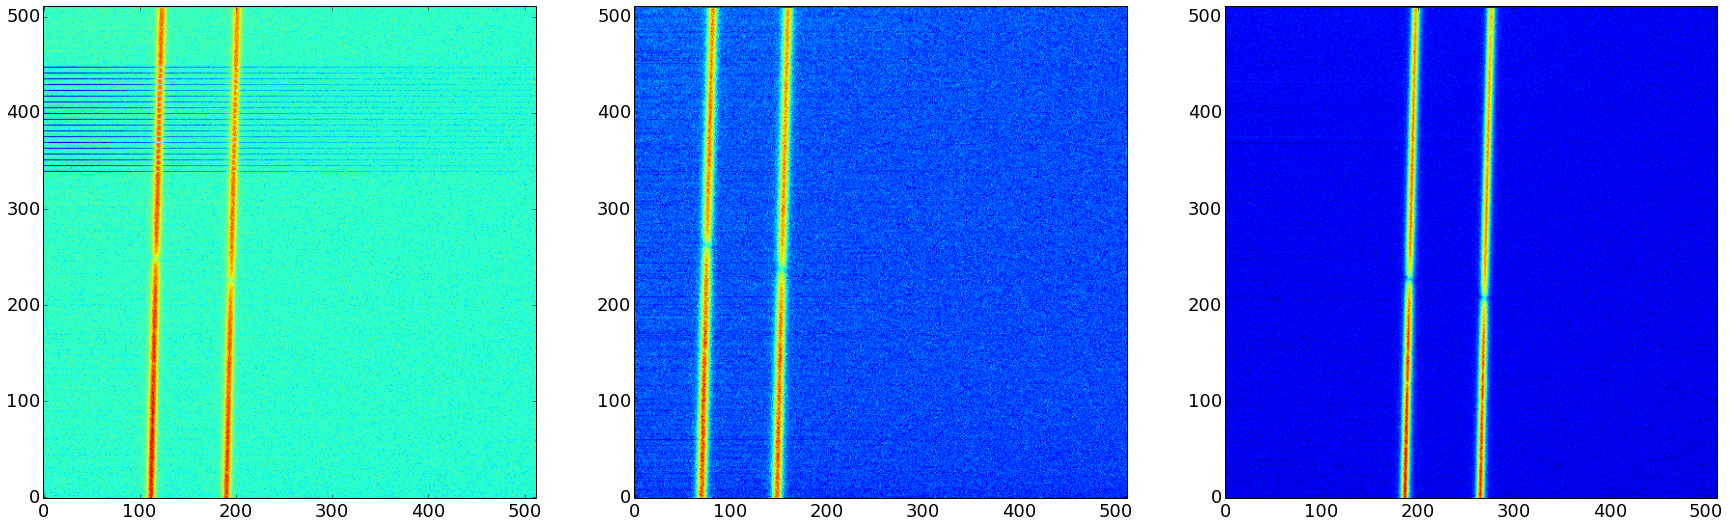

In [4]:
plt.figure(figsize=(30,10))
plt.subplot(131); plt.imshow(nud_01_data,origin='lower')
plt.subplot(132); plt.imshow(nud_02_data,origin='lower')
plt.subplot(133); plt.imshow(nud_03_data,origin='lower')

Well, one thing for sure: the spectra are not aligned with the y-axis. But we care more about the pre-/ab-sence of curvature. Similar to what is shown below for the plate scale, any linear effect can be corrected by a simple scaling factor. So long as the three images, six lines all show no significant curving, then we're safe to exploit the straightforward wavelength calibration.

#### Extract the spectra
To do proper fitting, we first take out the points of interest. For simplicity, I'll do only one spectrum from each image

In [5]:
delta = 20

lin1,lin2,lin3 = [],[],[]
for row in range(nud_01_data.shape[0]):
    pk01 = peakdet(nud_01_data[row],delta)
    pk02 = peakdet(nud_02_data[row],delta)
    pk03 = peakdet(nud_03_data[row],delta)
    
    ## column indices
    try:
        lin1.append(pk01[1,0])
    except:
        lin1.append(np.nan)
    try:
        lin2.append(pk02[1,0])
    except:
        lin2.append(np.nan)
    try:
        lin3.append(pk03[1,0])
    except:
        lin3.append(np.nan)
        
lin1=np.asarray(lin1)
lin2=np.asarray(lin2)
lin3=np.asarray(lin3)

In [6]:
%%capture
## get rid of mistakened values
lin1[lin1<180]=np.nan
lin3[lin3<260]=np.nan

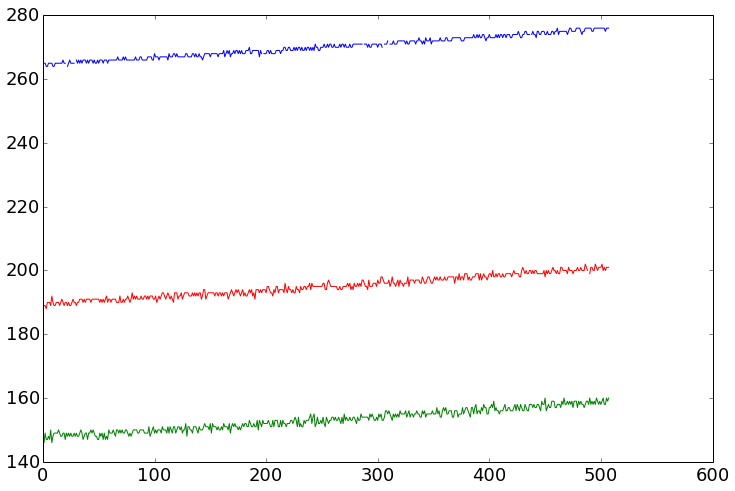

In [7]:
plt.figure(figsize=(12,8))
plt.plot(lin1,'r')
plt.plot(lin2,'g')
plt.plot(lin3,'b')

#### Fit quadratic curve 
I'll be lazy and show only that the quadratic power is negligibly small (I don't want to bother resorting to chi-square comparison and stuff like that...)

In [8]:
## example fit: lin1
xx = np.arange(len(lin1))

#-- clean up NaN values
idx = np.isfinite(lin1)
fit_2p = np.polyfit(xx[idx],lin1[idx],2)
fit_1p = np.polyfit(xx[idx],lin1[idx],1)

print 'Best-fit quad. is {0:.2e} x^2 + {1:.3f} x + {2:.2f}'.format(fit_2p[0],
                                                                   fit_2p[1],
                                                                   fit_2p[2])
print 'Best-fit line  is                {0:.3f} x + {1:.2f}'.format(fit_1p[0],
                                                                    fit_1p[1])

Best-fit quad. is 6.69e-06 x^2 + 0.019 x + 189.57
Best-fit line  is                0.023 x + 189.28


### 2. Plate scale is uniform
#### Uniform across columns 

Argument: If the plate scale across columns is fixed, the separation of the spectra of the two stars should be the same for the three images, regardless of which row it is measured.

Let's try somewhere around the 200th row, from the double star system again: 

In [9]:
slc = 200

nud_01_spec = nud_01_data[slc]
nud_02_spec = nud_02_data[slc]
nud_03_spec = nud_03_data[slc]

And finding the peaks

In [10]:
delta = 30
nud_01_pk = peakdet(nud_01_spec,delta)
nud_02_pk = peakdet(nud_02_spec,delta)
nud_03_pk = peakdet(nud_03_spec,delta)

Peak distance for 01 is 78.0 pixels
Peak distance for 02 is 78.0 pixels
Peak distance for 03 is 78.0 pixels
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


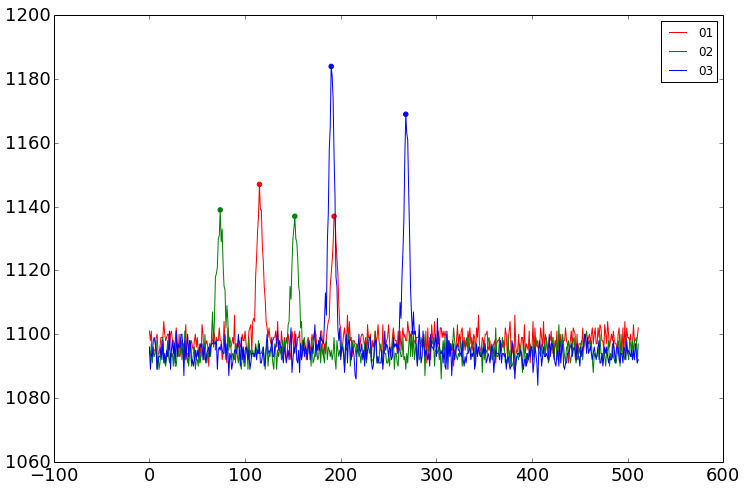

In [11]:
plt.figure(figsize=(12,8))
plt.plot(nud_01_spec,'r',label='01')
plt.plot(nud_02_spec,'g',label='02')
plt.plot(nud_03_spec,'b',label='03'); plt.legend()

plt.scatter(nud_01_pk[:,0], nud_01_pk[:,1], color='red')
plt.scatter(nud_02_pk[:,0], nud_02_pk[:,1], color='green')
plt.scatter(nud_03_pk[:,0], nud_03_pk[:,1], color='blue')

print 'Peak distance for 01 is {0} pixels'.format(nud_01_pk[1,0]-nud_01_pk[0,0])
print 'Peak distance for 02 is {0} pixels'.format(nud_02_pk[1,0]-nud_02_pk[0,0])
print 'Peak distance for 03 is {0} pixels'.format(nud_03_pk[1,0]-nud_03_pk[0,0])

Excellent. Very consistent. Now the angular separation of the two stars $\nu^1 Dra$ and $\nu^2 Dra$ is, according to their [coordinates](https://en.wikipedia.org/wiki/Nu_Draconis):

<img src='https://github.com/Mipanox/PHYS301/blob/master/Project/imgs/ang_sep.png?raw=true' width=80%> </img>

So the plate scale is

In [12]:
plate_scale = (0.0172*u.degree / (nud_01_pk[1,0]-nud_01_pk[0,0])).to(u.arcsec)
print 'Plate scale is {0:.5f}'.format(plate_scale)

np.save(workdir+'others/plate_scale.npy',plate_scale.value)

Plate scale is 0.79385 arcsec


**Note**: It should be noted that this value is larger than expected (nominal scale is 0.7 arcsec), and can be accounted for due to the "projection" effect of the slit onto a skewed line rather than perfectly aligned with the x-axis (along row). From this we can even estimate the angle of the projection to be

$$\theta\approx\cos^{-1}(\frac{0.7}{0.79385})\approx 28.14^\circ$$

which reasonably matches what we see, judged by eye

#### Linear along the slit in the ROI
The ROI is chosen in the analysis [notebook](https://nbviewer.jupyter.org/github/Mipanox/PHYS301/blob/master/Project/SpecAna.ipynb). Unfortunately, there's no Neon emission lines in the ROI. Hence, we have to zoom out a little bit to see two lines -- to calibrate wavelength

In [13]:
roi_x = np.load(workdir+'others/roi_x.npy')
roi_y = np.load(workdir+'others/roi_y.npy')

In [14]:
roi_yz = np.array((155,310))
np.save(workdir+'others/roi_yz.npy',roi_yz)

Examine the arc image:

(155, 310)

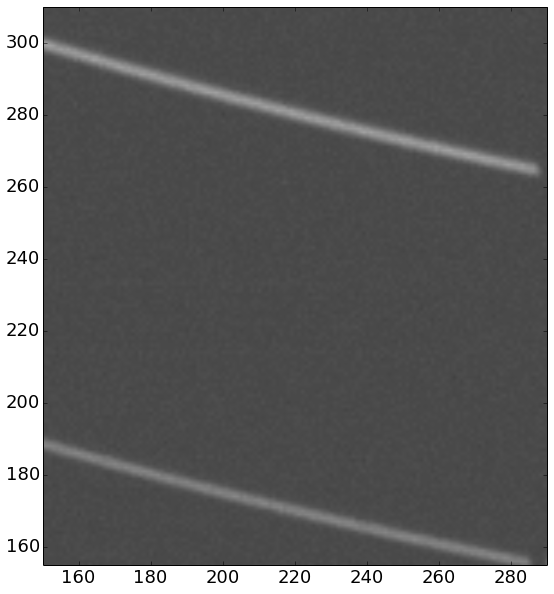

In [15]:
arc_data = pyfits.open(datdir+'Arc.fit')[0].data
arc_hdr  = pyfits.open(datdir+'Arc.fit')[0].header

plt.figure(figsize=(10,10))
plt.imshow(arc_data,origin='lower',cmap='gray'); plt.clim(1000,1400)
plt.xlim(roi_x); plt.ylim(roi_yz)

There's only one emission line conspicuous in this region. Since I'm lazy, I'll wave my hands and claim that the line is rough straight, so the single plate scale scaling is justified. 
> **Warning**: This is NOT saying that the reference standord wavelengths can be taken as simple straight lines. We do that column by column so we won't be biased by any sketchy assumptions like this. But here it's only to show that the plate scale can be regarded approximately as a constant...

### 3. Center fo galaxy
Literature shows that the H-$\alpha$ emission of M82 is actually very asymmetric (e.g. Strickland+[2004](http://iopscience.iop.org/article/10.1086/382214)). So the apparent center of the spectrum might not represent the physical center defined by the central X-ray source

> a more subtle story can be found at NASA's articles [here](https://www.nasa.gov/jpl/nustar/pia18844) and [here](https://www.nasa.gov/press/2014/october/nasa-s-nustar-telescope-discovers-shockingly-bright-dead-star); we'll assume that the bright spot lies right at the center - indeed, the position agrees with the bipolar jet: see [Spitzer](http://www.spitzer.caltech.edu/images/2205-sig06-010-M82-Great-Observatories-Present-Rainbow-of-a-Galaxy) or [HST](https://en.wikipedia.org/wiki/Messier_82) images in IR. 

The optical (photometry) image is then used to determine the true center on the spectral image

#### Slit camera images
Knowing the position of the point source like the double star, the spatial projection onto the spectral images can be determined

In [16]:
slitdir = datdir+'g2_Final_060117/'

In [17]:
## 
slit_nud_01_data = pyfits.open(slitdir+'Focus._nu_Drac_01.fit')[0].data
slit_nud_01_hdr  = pyfits.open(slitdir+'Focus._nu_Drac_01.fit')[0].header

## 
slit_nud_03_data = pyfits.open(slitdir+'Focus._nu_Drac_03.fit')[0].data
slit_nud_03_hdr  = pyfits.open(slitdir+'Focus._nu_Drac_03.fit')[0].header

## M82
slit_M82_data = pyfits.open(slitdir+'Focus_M82_1h_bef.fit')[0].data
slit_M82_hdr  = pyfits.open(slitdir+'Focus_M82_1h_bef.fit')[0].header

(200, 400)

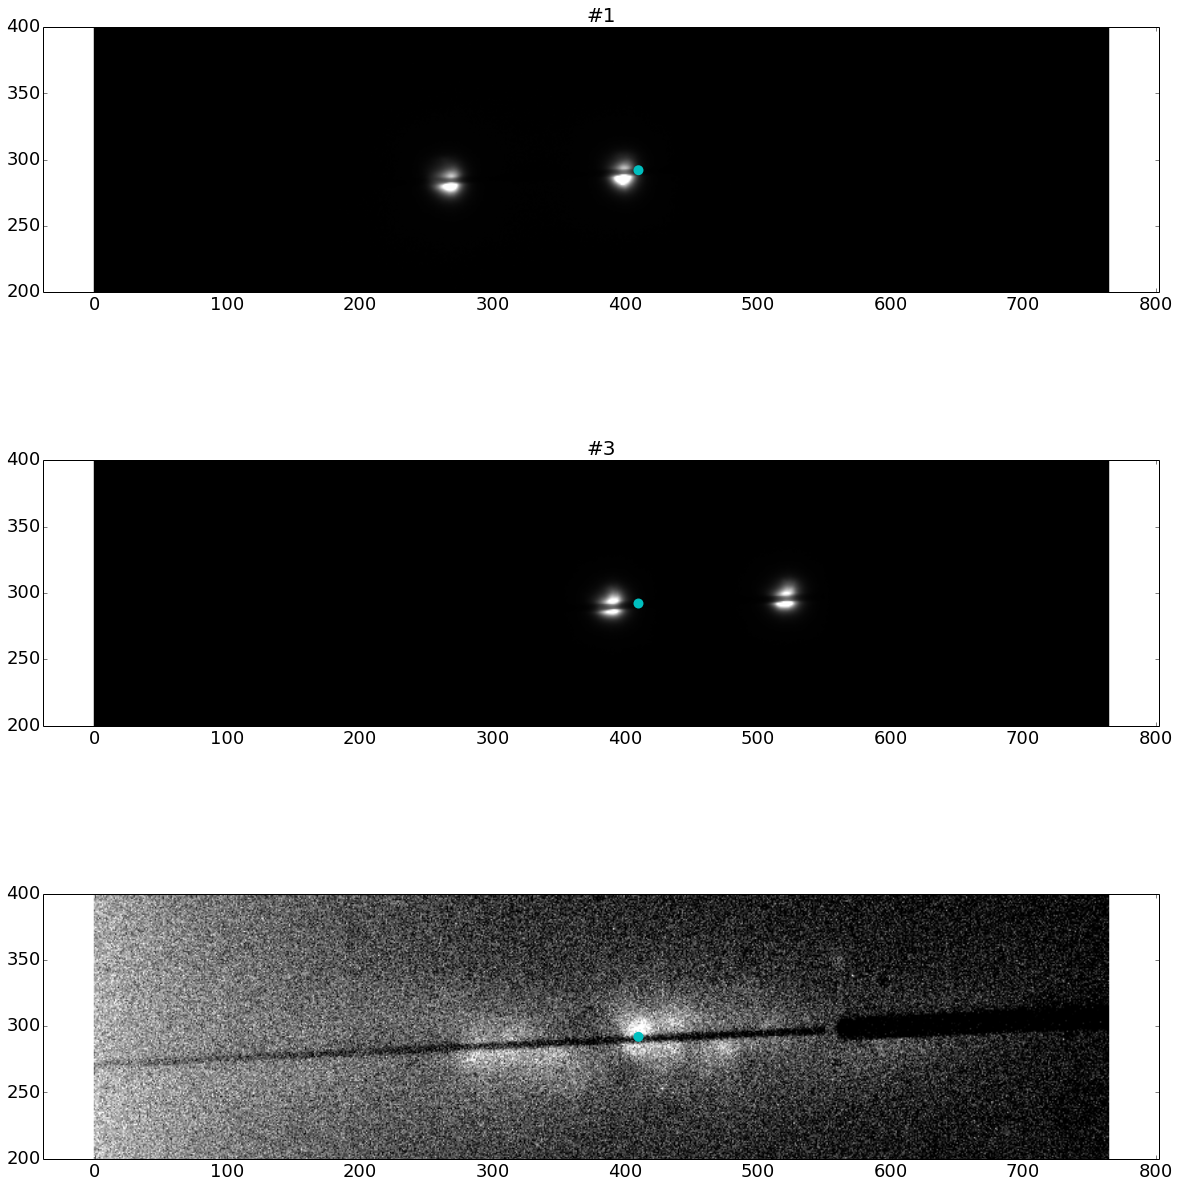

In [18]:
ulx_x,ulx_y = 410,292

plt.figure(figsize=(20,22))
plt.subplot(311); plt.imshow(slit_nud_01_data,origin='lower',cmap='gray')
plt.scatter(ulx_x,ulx_y,c='c',s=100,lw=0)
plt.ylim(200,400); plt.title('#1')

plt.subplot(312); plt.imshow(slit_nud_03_data,origin='lower',cmap='gray')
plt.scatter(ulx_x,ulx_y,c='c',s=100,lw=0)
plt.ylim(200,400); plt.title('#3')

plt.subplot(313); plt.imshow(slit_M82_data,origin='lower',cmap='gray'); plt.clim(1220,1300)
plt.scatter(ulx_x,ulx_y,c='c',s=100,lw=0)
plt.ylim(200,400)

The cyan spot resides right on top of the ULX _(The ones displayed on the double star images are simply a sanity check that the camera was not shifted or modified otherwise)_

Compare with photometry image confirms this:

(170, 300)

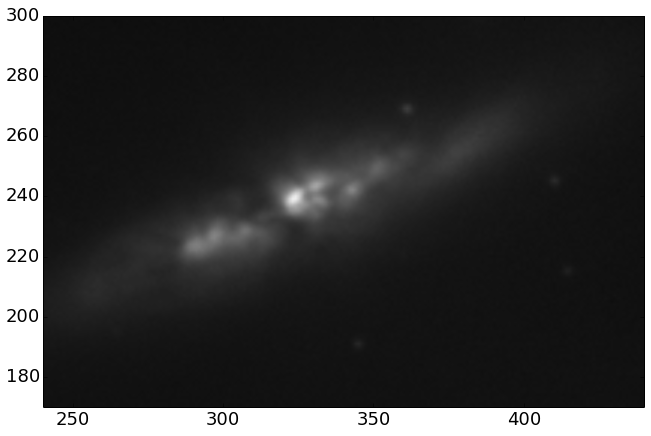

In [19]:
phodir = '/afs/.ir/users/i/a/iameric/physics100/workdir/g2/final/image/R/coadd/coadd.fits'
pho = pyfits.open(phodir)[0].data

plt.figure(figsize=(12,7))
plt.imshow(pho,origin='lower',cmap='gray'); plt.clim(700,4000)
plt.xlim(240,440); plt.ylim(170,300)

#### Projection onto the spetral image
Now, this is non-trivial as the spectra were skewed (see above for double star system's spectra) so formally one has to match both spatially and in wavelength. Nonethless, we're lucky that one of the stars in one of the three images sit roughly on the spot. We'll use this to our advantage

(200, 280)

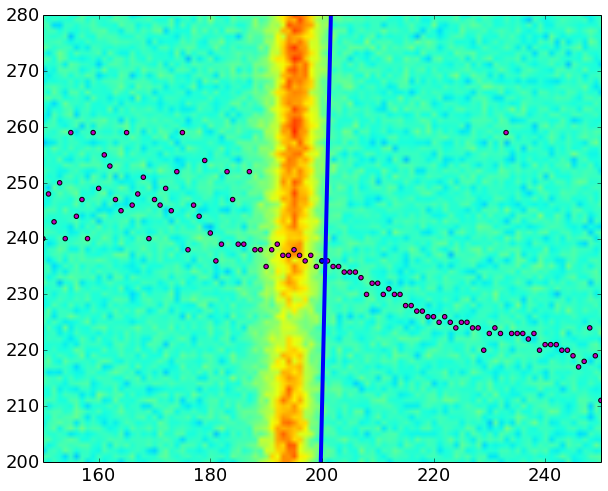

In [20]:
## revisit double star spectrum of #1
plt.figure(figsize=(10,10))
plt.imshow(nud_01_data,origin='lower')

## overlay H-alpha peaks in data
peak_x = np.load(workdir+'others/Halp_peak_x.npy')
peak_y = np.load(workdir+'others/Halp_peak_y.npy')

plt.scatter(peak_x,peak_y,c='m')

## overlay the best-fit line plus some 
#  shift accounting for the slight mismatch of center and star
shift = 6
plt.plot(xx*fit_1p[0]+fit_1p[1]+shift,xx,lw=4)

plt.scatter(peak_x[50],peak_y[50])

plt.xlim(150,250); plt.ylim(200,280)

The interception occurs at approximately the pixel coordinates

In [21]:
peak_x[50],peak_y[50]

(200, 236)

In [22]:
np.save(workdir+'others/ctr_x_pix.npy',peak_x[50]-roi_x[0])

### 4. Effective binning size
The binning size can be determined by the relative drifting of the sky during the observation. While using the nearby bright star as the tracker, the observation was noted to possess ~half "radius" of the star drifting over the course. In other words, the corresponding spatial size should compose the error bar(s) in the spatial direction, and points within such distance should be binned together

Zoom in to the tracker to read off the size:

(430, 475)

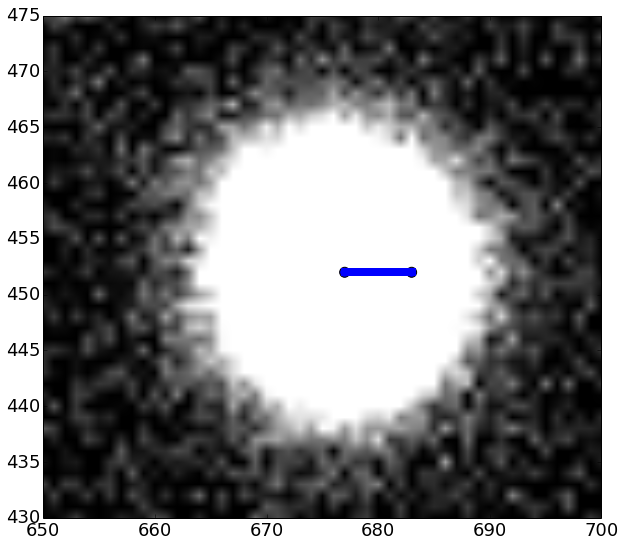

In [37]:
scx, scy = 677, 452
binsize = np.array([6])

plt.figure(figsize=(10,10))
plt.imshow(slit_M82_data,origin='lower',cmap='gray'); plt.clim(1220,1300)
plt.scatter([scx,scx+binsize],[scy,scy],s=100); plt.plot([scx,scx+binsize],[scy,scy],lw=8)
plt.xlim(650,700); plt.ylim(430,475)

Here denotes the size we take

In [38]:
np.save(workdir+'others/binsize.npy',binsize)

In [ ]:
0.03

### 5. Dominating contribution of uncertainty
#### Velocity
Contributing factors for uncertainties in velocity (y-axis) are
1. **Instrumental limitation** - $\approx$0.8A$\approx$36.5km/s
2. **Peak determination** - $\lesssim0.4km/s$
> the fact that the spectral lines are "histograms" of incoming photons. Determining a peak is thus equivalent to finding a mean value. And the error in mean is scaled as $\sigma1/\sqrt{N}$, where $\sigma$ is the $\sigma$ for the Gaussian-like distributed line profiles and N is the total photon counts, which should be on the other of ~1000 (according to image; assuming gain of order 1). So $1/\sqrt{N}\sim0.03\times2.5\sim0.35km/s$, where 2.5 is a typical $\sigma$ of a line in Angstrom 
3. **Binning** - on the order of 50km/s: statistical scattering

<br>
<font color="brown">Factor 2 is considerably smaller than 3., while 1. has been taken into account when convolving the Gaussians to find peaks. Therefore, 3. is the dominating factor and we shall assume 1. and 2. to be zero when evaluating error bars</font>

#### Spatial
1. **Instrumental limitation** - $\approx 0.8"$
> this is just the plate scale
2. **Binning** - $\approx 2.5"$
> effective binning number (one side) times plate scale

<br>
<font color="brown">Once more, factor 2 is governing the uncertainties</font>